C:\Users\Furkan\anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\Furkan\anaconda3\envs\pytorch\lib\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


# Train Samples: 9433
# Val   Samples: 1189
# Test  Samples: 1166
Train unique classes: 160
Val   unique classes: 20
Test  unique classes: 20
Total unique classes across splits: 200

Visualizing some Train Samples:


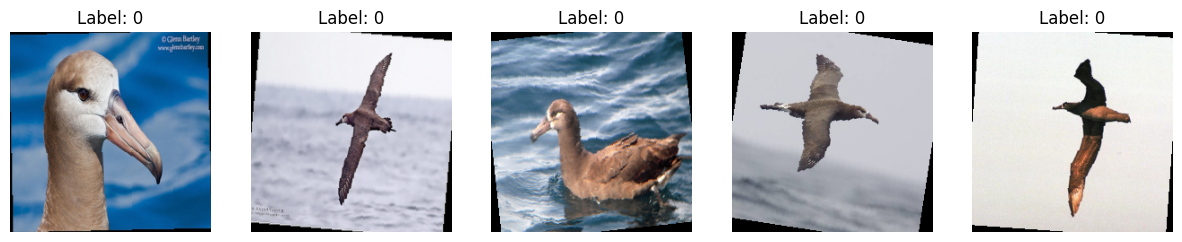


Visualizing some Val Samples:


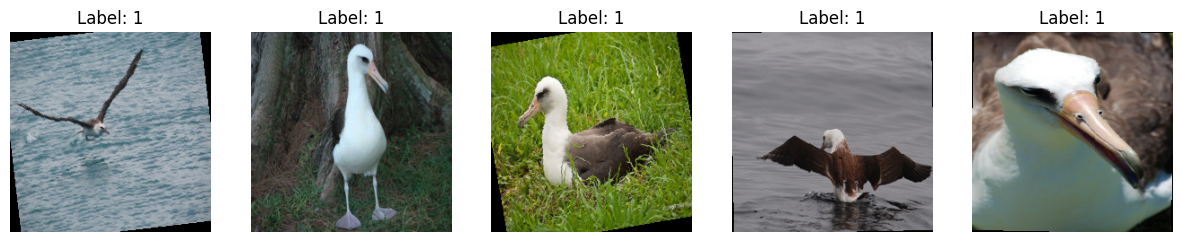


Starting Training...
Episode 1/1000, Loss: 0.000027, Accuracy: 100.00%, Time/Episode: 11.99s, Elapsed: 11.99s, Remaining: ~11982.64s
[Validation] Episode 10, Accuracy: 97.87%
[Validation] Episode 20, Accuracy: 97.41%
[Validation] Episode 30, Accuracy: 97.68%
[Validation] Episode 40, Accuracy: 97.39%
[Validation] Episode 50, Accuracy: 98.11%
Episode 51/1000, Loss: 0.009385, Accuracy: 100.00%, Time/Episode: 12.00s, Elapsed: 785.25s, Remaining: ~14611.81s
[Validation] Episode 60, Accuracy: 98.43%
[Validation] Episode 70, Accuracy: 98.00%
[Validation] Episode 80, Accuracy: 98.27%
[Validation] Episode 90, Accuracy: 98.48%
[Validation] Episode 100, Accuracy: 97.63%
Episode 101/1000, Loss: 0.277634, Accuracy: 86.67%, Time/Episode: 12.16s, Elapsed: 1559.61s, Remaining: ~13882.09s
[Validation] Episode 110, Accuracy: 98.83%
[Validation] Episode 120, Accuracy: 98.00%
[Validation] Episode 130, Accuracy: 98.21%
[Validation] Episode 140, Accuracy: 98.56%
[Validation] Episode 150, Accuracy: 98.61%
E

Evaluating: 100%|██████████| 100/100 [01:06<00:00,  1.51it/s]


Per-episode Accuracies:
 Episode  1: 93.33%
 Episode  2: 98.67%
 Episode  3: 97.33%
 Episode  4: 98.67%
 Episode  5: 81.33%
 Episode  6: 94.67%
 Episode  7: 96.00%
 Episode  8: 96.00%
 Episode  9: 97.33%
 Episode 10: 100.00%
 Episode 11: 100.00%
 Episode 12: 98.67%
 Episode 13: 97.33%
 Episode 14: 97.33%
 Episode 15: 100.00%
 Episode 16: 100.00%
 Episode 17: 98.67%
 Episode 18: 98.67%
 Episode 19: 96.00%
 Episode 20: 96.00%
 Episode 21: 100.00%
 Episode 22: 93.33%
 Episode 23: 100.00%
 Episode 24: 98.67%
 Episode 25: 97.33%
 Episode 26: 98.67%
 Episode 27: 96.00%
 Episode 28: 98.67%
 Episode 29: 94.67%
 Episode 30: 98.67%
 Episode 31: 98.67%
 Episode 32: 94.67%
 Episode 33: 96.00%
 Episode 34: 97.33%
 Episode 35: 96.00%
 Episode 36: 97.33%
 Episode 37: 92.00%
 Episode 38: 100.00%
 Episode 39: 98.67%
 Episode 40: 96.00%
 Episode 41: 96.00%
 Episode 42: 97.33%
 Episode 43: 97.33%
 Episode 44: 100.00%
 Episode 45: 96.00%
 Episode 46: 96.00%
 Episode 47: 98.67%
 Episode 48: 97.33%
 Episod

In [1]:
import os
import time
import torch
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm
from collections import defaultdict

from torch.utils.data import Dataset
import torchvision.transforms as transforms

import timm
from timm.models.vision_transformer import VisionTransformer
from timm.models.layers import to_2tuple

# 1. Enable Synchronous CUDA Error Reporting
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

# ---------------------------------------------------------------------
# 2. Define Constants and Paths
# ---------------------------------------------------------------------
CUB_PATH = r"C:\Users\Furkan\Desktop\CUB_200_2011"
IMAGES_FOLDER           = os.path.join(CUB_PATH, "images")
CLASSES_TXT            = os.path.join(CUB_PATH, "classes.txt")
IMAGES_TXT             = os.path.join(CUB_PATH, "images.txt")
IMAGE_CLASS_LABELS_TXT = os.path.join(CUB_PATH, "image_class_labels.txt")
# Note: We IGNORE train_test_split.txt in this approach, because we do class-based splits.

IMG_SIZE = 224
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

EPISODES = 1000   # Number of training episodes
SHOTS = 5
QUERY = 15
NUM_CLASSES_PER_EPISODE = 5

EVAL_FREQUENCY = 10

# ---------------------------------------------------------------------
# 3. Load CUB metadata with CLASS-BASED 80/10/10 splits
# ---------------------------------------------------------------------
def load_cub_metadata_class_splits(
    classes_txt=CLASSES_TXT,
    images_txt=IMAGES_TXT,
    labels_txt=IMAGE_CLASS_LABELS_TXT,
    train_ratio=0.8,
    val_ratio=0.1,
    test_ratio=0.1
):
    """
    Returns three lists: train_data, val_data, test_data
    Each is a list of (relative_image_path, class_id).

    STEPS:
    1) Parse classes.txt, which typically has 200 lines:
          "1 001.Black_footed_Albatross"
          "2 002.Laysan_Albatross"
          ...
       We'll map each line -> (class_id, class_name).
       class_id runs [1..200].

    2) Shuffle the list of class_ids. Then slice them into:
         - train_class_ids   (80% of them)
         - val_class_ids     (10%)
         - test_class_ids    (10%)

    3) Read images.txt -> image_id -> relative_path
    4) Read image_class_labels.txt -> image_id -> class_id

    5) For each image, check which class_id it belongs to.
       If that class_id is in train_class_ids => train_data, etc.
    """

    # 3.1 Read classes.txt -> list of (class_id, class_name)
    # e.g. "1 001.Black_footed_Albatross"
    class_id_to_name = {}
    with open(classes_txt, "r") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            parts = line.split(maxsplit=1)
            cid = int(parts[0])        # 1..200
            cname = parts[1]          # "001.Black_footed_Albatross"
            class_id_to_name[cid] = cname

    all_class_ids = list(class_id_to_name.keys())  # [1..200]
    all_class_ids.sort()  # Usually 1..200

    # Shuffle class IDs
    random.shuffle(all_class_ids)

    # 3.2 Class-based split
    num_total_classes = len(all_class_ids)  # typically 200
    train_end = int(train_ratio * num_total_classes)
    val_end   = int((train_ratio + val_ratio) * num_total_classes)

    train_class_ids = set(all_class_ids[:train_end])
    val_class_ids   = set(all_class_ids[train_end:val_end])
    test_class_ids  = set(all_class_ids[val_end:])

    # 3.3 Read images.txt -> image_id => relative_path
    img_id_to_path = {}
    with open(images_txt, "r") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            # typically: "1 001.Black_footed_Albatross/Black_Footed_Albatross_0001_796111.jpg"
            parts = line.split(maxsplit=1)
            img_id = int(parts[0])
            rel_path = parts[1]
            img_id_to_path[img_id] = rel_path

    # 3.4 Read image_class_labels.txt -> image_id => class_id
    img_id_to_label = {}
    with open(labels_txt, "r") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            # e.g. "1 1"
            parts = line.split()
            img_id = int(parts[0])
            cid = int(parts[1])  # class in [1..200]
            img_id_to_label[img_id] = cid

    # 3.5 Build (rel_path, label) lists for train/val/test
    train_data = []
    val_data   = []
    test_data  = []

    for img_id, rel_path in img_id_to_path.items():
        cid = img_id_to_label[img_id]  # [1..200]
        # Check which set this class belongs to
        if cid in train_class_ids:
            train_data.append((rel_path, cid))
        elif cid in val_class_ids:
            val_data.append((rel_path, cid))
        elif cid in test_class_ids:
            test_data.append((rel_path, cid))
        else:
            # Should never happen if we covered all classes
            pass

    return train_data, val_data, test_data

# ---------------------------------------------------------------------
# 4. CUB Dataset Class
# ---------------------------------------------------------------------
class CUBDataset(Dataset):
    """
    Expects a list of (image_relative_path, label) pairs and a root images folder.
    Shifts the label from [1..200] to [0..199] for zero-based indexing.
    """
    def __init__(self, data_list, root_images_folder, transform=None):
        super().__init__()
        self.data_list = data_list
        self.root_images_folder = root_images_folder
        self.transform = transform

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        rel_path, label = self.data_list[idx]
        full_path = os.path.join(self.root_images_folder, rel_path)
        
        # Load PIL image
        img = Image.open(full_path).convert("RGB")

        if self.transform is not None:
            img = self.transform(img)

        # Shift label to zero-based
        # CUB classes are [1..200], so do label-1
        label = label - 1

        return img, label

# ---------------------------------------------------------------------
# 5. Prepare Datasets & class_to_indices
# ---------------------------------------------------------------------
train_data_list, val_data_list, test_data_list = load_cub_metadata_class_splits(
    classes_txt=CLASSES_TXT,
    images_txt=IMAGES_TXT,
    labels_txt=IMAGE_CLASS_LABELS_TXT,
    train_ratio=0.8,
    val_ratio=0.1,
    test_ratio=0.1
)

# Define transforms
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

train_dataset = CUBDataset(train_data_list, IMAGES_FOLDER, transform=transform)
val_dataset   = CUBDataset(val_data_list,   IMAGES_FOLDER, transform=transform)
test_dataset  = CUBDataset(test_data_list,  IMAGES_FOLDER, transform=transform)

print(f"# Train Samples: {len(train_dataset)}")
print(f"# Val   Samples: {len(val_dataset)}")
print(f"# Test  Samples: {len(test_dataset)}")

# Build class_to_indices for each split
class_to_indices_train = defaultdict(list)
for idx in range(len(train_dataset)):
    _, lbl = train_dataset[idx]
    class_to_indices_train[lbl].append(idx)

class_to_indices_val = defaultdict(list)
for idx in range(len(val_dataset)):
    _, lbl = val_dataset[idx]
    class_to_indices_val[lbl].append(idx)

class_to_indices_test = defaultdict(list)
for idx in range(len(test_dataset)):
    _, lbl = test_dataset[idx]
    class_to_indices_test[lbl].append(idx)

print(f"Train unique classes: {len(class_to_indices_train)}")
print(f"Val   unique classes: {len(class_to_indices_val)}")
print(f"Test  unique classes: {len(class_to_indices_test)}")

# Number of classes in dataset
all_labels = set(class_to_indices_train.keys()) \
             | set(class_to_indices_val.keys()) \
             | set(class_to_indices_test.keys())
num_all_labels = len(all_labels)
print(f"Total unique classes across splits: {num_all_labels}")

# ---------------------------------------------------------------------
# 6. Define Pretrained ViT with Dropout
# ---------------------------------------------------------------------
class PretrainedViTWithAttention(VisionTransformer):
    def __init__(self, num_classes, pretrained=True, drop_rate=0.1):
        # vit_small_patch16_224 has embed_dim=384, num_heads=6, depth=12
        super().__init__(
            img_size=224,
            patch_size=16,
            in_chans=3,
            num_classes=num_classes,
            embed_dim=384,
            depth=12,
            num_heads=6,
            mlp_ratio=4.0,
            qkv_bias=True,
            norm_layer=torch.nn.LayerNorm,
            drop_rate=drop_rate   # Add dropout
        )
        if pretrained:
            # Create a smaller timm ViT backbone with no classification head
            base_model = timm.create_model(
                "vit_small_patch16_224",
                pretrained=True,
                num_classes=0,
                drop_rate=drop_rate
            )
            state_dict = base_model.state_dict()
            self.load_state_dict(state_dict, strict=False)

    def forward(self, x):
        x = self.forward_features(x)
        x = self.head(x)  # classification head
        return x

    def forward_features(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)
        cls_token = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_token, x), dim=1)
        x = x + self.pos_embed
        x = self.pos_drop(x)
        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)
        return x[:, 0]  # CLS token

# ---------------------------------------------------------------------
# 7. Initialize Model
# ---------------------------------------------------------------------
model = PretrainedViTWithAttention(
    num_classes=num_all_labels,
    pretrained=True,
    drop_rate=0.1
).to(DEVICE)

# ---------------------------------------------------------------------
# 8. Prototypical Network Utilities
# ---------------------------------------------------------------------
def compute_prototypes(features, labels):
    unique_labels = torch.unique(labels)
    prototypes = []
    for ul in unique_labels:
        class_features = features[labels == ul]
        prototypes.append(class_features.mean(dim=0))
    return torch.stack(prototypes), unique_labels

def classify(features, prototypes):
    # Negative Euclidean distance => "logits"
    dists = torch.cdist(features, prototypes)  # [batch_size, num_classes_in_episode]
    return -dists

def clip_gradients(optimizer, max_norm=1.0):
    for group in optimizer.param_groups:
        for param in group['params']:
            if param.grad is not None:
                torch.nn.utils.clip_grad_norm_(param, max_norm)

def debug_batch(images, labels, logits, loss):
    print(f"Images shape: {images.shape}")
    print(f"Labels: {labels}")
    print(f"Logits: {logits}")
    print(f"Loss: {loss}")

# ---------------------------------------------------------------------
# 9. Episodic Batch Sampler
# ---------------------------------------------------------------------
def episodic_batch_custom(dataset, class_to_indices, shots, query, num_classes_per_episode=5):
    """ 
    Create an episodic batch from 'dataset' given the label->indices dictionary 'class_to_indices'.
    We randomly select 'num_classes_per_episode' classes. For each chosen class,
    we randomly pick 'shots' for support + 'query' for query.
    """
    selected_classes = random.sample(list(class_to_indices.keys()), num_classes_per_episode)

    support_images, support_labels = [], []
    query_images, query_labels = [], []

    for cls in selected_classes:
        indices = class_to_indices[cls]
        if len(indices) < (shots + query):
            raise ValueError(
                f"Not enough samples for class '{cls}' "
                f"(need {shots + query}, have {len(indices)})"
            )

        chosen = random.sample(indices, shots + query)
        s_idx = chosen[:shots]
        q_idx = chosen[shots:]

        for i in s_idx:
            image, label = dataset[i]
            support_images.append(image)
            support_labels.append(label)

        for i in q_idx:
            image, label = dataset[i]
            query_images.append(image)
            query_labels.append(label)

    support_images = torch.stack(support_images).to(DEVICE)
    support_labels = torch.tensor(support_labels, dtype=torch.long).to(DEVICE)
    query_images   = torch.stack(query_images).to(DEVICE)
    query_labels   = torch.tensor(query_labels, dtype=torch.long).to(DEVICE)

    return support_images, support_labels, query_images, query_labels

# ---------------------------------------------------------------------
# 10. Train Function
# ---------------------------------------------------------------------
def train_prototypical_network_custom(
    model,
    train_dataset,
    class_to_indices_train,
    val_dataset,
    class_to_indices_val,
    optimizer,
    criterion,
    episodes,
    shots,
    query,
    num_classes_per_episode=5,
    eval_freq=50
):
    model.train()
    start_time = time.time()

    for episode in range(1, episodes + 1):
        episode_start = time.time()

        try:
            # Create an episodic batch from the train set
            support_images, support_labels, query_images, query_labels = episodic_batch_custom(
                train_dataset,
                class_to_indices_train,
                shots,
                query,
                num_classes_per_episode
            )

            # Forward
            support_feats = model.forward_features(support_images)
            query_feats   = model.forward_features(query_images)

            prototypes, unique_labels_ep = compute_prototypes(support_feats, support_labels)
            logits = classify(query_feats, prototypes)

            # Map global labels to local (episode) labels
            mapped_query_labels = torch.zeros_like(query_labels)
            for idx_local, label_global in enumerate(unique_labels_ep):
                mapped_query_labels[query_labels == label_global] = idx_local

            loss = criterion(logits, mapped_query_labels)

            # Compute accuracy
            preds = torch.argmax(logits, dim=1)
            train_acc = (preds == mapped_query_labels).float().mean().item()

            # Safety check
            if torch.isnan(loss) or torch.isinf(loss):
                debug_batch(query_images, query_labels, logits, loss)
                raise ValueError("Loss is NaN or Inf")

            optimizer.zero_grad()
            loss.backward()
            clip_gradients(optimizer)
            optimizer.step()

        except Exception as e:
            print(f"Error in episode {episode}: {e}")
            continue

        # Print training info
        episode_end = time.time()
        duration = episode_end - episode_start

        # Print occasionally
        if episode % 50 == 1 or episode == 1:
            elapsed = episode_end - start_time
            avg_per_episode = elapsed / episode
            remaining = (episodes - episode) * avg_per_episode
            print(f"Episode {episode}/{episodes}, "
                  f"Loss: {loss.item():.6f}, "
                  f"Accuracy: {train_acc * 100:.2f}%, "
                  f"Time/Episode: {duration:.2f}s, "
                  f"Elapsed: {elapsed:.2f}s, "
                  f"Remaining: ~{remaining:.2f}s")

        # Evaluate periodically
        if episode % eval_freq == 0:
            val_acc, _, _ = evaluate_prototypical_network_custom(
                model,
                val_dataset,
                class_to_indices_val,
                shots,
                query,
                episodes=50,
                num_classes_per_episode=num_classes_per_episode,
                verbose=False
            )
            print(f"[Validation] Episode {episode}, Accuracy: {val_acc*100:.2f}%")

# ---------------------------------------------------------------------
# 11. Eval Function
# ---------------------------------------------------------------------
def evaluate_prototypical_network_custom(
    model,
    test_dataset,
    class_to_indices_test,
    shots,
    query,
    episodes,
    num_classes_per_episode=5,
    verbose=True
):
    model.eval()
    per_episode_accuracies = []

    with torch.no_grad():
        iterator = range(1, episodes + 1)
        if verbose:
            iterator = tqdm(iterator, desc="Evaluating")

        for _ in iterator:
            try:
                s_imgs, s_lbls, q_imgs, q_lbls = episodic_batch_custom(
                    test_dataset,
                    class_to_indices_test,
                    shots,
                    query,
                    num_classes_per_episode
                )
                s_feats = model.forward_features(s_imgs)
                q_feats = model.forward_features(q_imgs)
                prototypes, unique_labels_ep = compute_prototypes(s_feats, s_lbls)
                logits = classify(q_feats, prototypes)

                # Map global to local
                mapped_q_labels = torch.zeros_like(q_lbls)
                for i_local, g_label in enumerate(unique_labels_ep):
                    mapped_q_labels[q_lbls == g_label] = i_local

                preds_local = torch.argmax(logits, dim=1)
                preds_global = unique_labels_ep[preds_local]

                correct_this_episode = (preds_global == q_lbls).sum().item()
                total_this_episode   = q_lbls.size(0)
                episode_acc = correct_this_episode / total_this_episode
                per_episode_accuracies.append(episode_acc)

            except Exception as e:
                if verbose:
                    print("Eval error:", e)
                # skip this episode
                continue

    if len(per_episode_accuracies) == 0:
        if verbose:
            print("No episodes successfully evaluated.")
        return 0.0, 0.0, []

    # Average accuracy
    avg_acc = np.mean(per_episode_accuracies)
    # Standard deviation
    std_dev = np.std(per_episode_accuracies, ddof=1)
    # 95% Confidence Interval
    ci95 = 1.96 * (std_dev / np.sqrt(len(per_episode_accuracies)))

    if verbose:
        print("\nPer-episode Accuracies:")
        for i, ep_acc in enumerate(per_episode_accuracies, 1):
            print(f" Episode {i:2d}: {ep_acc*100:.2f}%")

        print(f"\nAverage Accuracy: {avg_acc*100:.2f}%")
        print(f"95% CI: ±{ci95*100:.2f}%")

    return avg_acc, ci95, per_episode_accuracies

# ---------------------------------------------------------------------
# 12. Visualization (Optional)
# ---------------------------------------------------------------------
def visualize_samples(dataset, num_samples=5):
    plt.figure(figsize=(15, 3))
    count = 0
    for i in range(len(dataset)):
        if count >= num_samples:
            break
        img, lbl = dataset[i]
        # Convert image from tensor to numpy for plotting
        if isinstance(img, torch.Tensor):
            img_np = img.cpu().numpy().transpose(1,2,0)
            # Unnormalize
            img_np = (img_np * 0.5) + 0.5
        else:
            img_np = np.array(img)

        plt.subplot(1, num_samples, count+1)
        plt.imshow(img_np)
        plt.title(f"Label: {lbl}")
        plt.axis('off')
        count += 1
    plt.show()

# ---------------------------------------------------------------------
# 13. Create Optimizer & Criterion
# ---------------------------------------------------------------------
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()

# ---------------------------------------------------------------------
# 14. Visualize Some Samples
# ---------------------------------------------------------------------
print("\nVisualizing some Train Samples:")
visualize_samples(train_dataset, num_samples=5)

print("\nVisualizing some Val Samples:")
visualize_samples(val_dataset, num_samples=5)

# ---------------------------------------------------------------------
# 15. Train the Prototypical Network
# ---------------------------------------------------------------------
print("\nStarting Training...")
train_prototypical_network_custom(
    model=model,
    train_dataset=train_dataset,
    class_to_indices_train=class_to_indices_train,
    val_dataset=val_dataset,
    class_to_indices_val=class_to_indices_val,
    optimizer=optimizer,
    criterion=criterion,
    episodes=EPISODES,
    shots=SHOTS,
    query=QUERY,
    num_classes_per_episode=NUM_CLASSES_PER_EPISODE,
    eval_freq=EVAL_FREQUENCY
)

# ---------------------------------------------------------------------
# 16. Final Evaluation on Test Set
# ---------------------------------------------------------------------
print("\nFinal Evaluation on Test Set...")
test_avg_acc, test_ci95, per_episode_accs = evaluate_prototypical_network_custom(
    model=model,
    test_dataset=test_dataset,
    class_to_indices_test=class_to_indices_test,
    shots=SHOTS,
    query=QUERY,
    episodes=100,
    num_classes_per_episode=NUM_CLASSES_PER_EPISODE
)

print(f"\nTest Accuracy: {test_avg_acc*100:.2f}% ±{test_ci95*100:.2f}%")

# ---------------------------------------------------------------------
# 17. Save the Trained Model
# ---------------------------------------------------------------------
save_path = os.path.join(CUB_PATH, "prototypical_network_vit_small_cub200_classsplit.pth")
torch.save(model.state_dict(), save_path)
print(f"Model saved at {save_path}")
